# Maximum Likelihood Estimation
### 最尤推定法

注意：このノートブックはPython3および(GPUを用いない)CPU環境で動作するように設定されています。<br>
Google Colab環境にてオンラインで実行する場合、オリジナルサイトのコードを使って下さい。<br>
GPUの有無に関わらずPython 3.x および　TensorFlow 2.xにて1.x環境を実行可能にする設定（ないしTensorFlow 1.x） にて、オフラインにて稼動するよう変更しています。<br>
2020/02/04: By H.Nishiyama<br>

このノートブックはTensorFlow 2.x (ないし1.x）を使います<br>
*もし、オンラインのCloabシステムを使うなら、オリジナルサイトのコードを使うか、次のセルを指示通りに修正して下さい。<br>
【オリジナルサイト】https://github.com/enakai00/colab_tfbook<br>
オリジナルではTensorFlow 2.x を対象としています。<br>

In [1]:
###%tensorflow_version 2.x

####[MLE-01]
Import modules and set a random seed.

In [2]:
# 必要なライブラリの読み込み　(少し時間がかかります)
import numpy as np
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

# 乱数生成の初期化
np.random.seed(20190220)
#--- For TensorFlow 1.x, use the following line, but if you use TensorFlow2.x, you need to comment it out.
###tf.random.set_random_seed(20190220)
#--- For TensorFlow 2.x, use following line, instead of upper line.
tf.random.set_seed(20190220)

####[MLE-02]
Generate a training dateset.

In [3]:
# 非感染群
# n0:乱数の数、mu0：平均値、variance0: 共分散
n0, mu0, variance0 = 20, [10, 11], 20
data0 = multivariate_normal(mu0, np.eye(2)*variance0 ,n0)
df0 = DataFrame(data0, columns=['x1', 'x2'])
df0['t'] = 0

# 感染群
n1, mu1, variance1 = 15, [18, 20], 22
data1 = multivariate_normal(mu1, np.eye(2)*variance1, n1)
df1 = DataFrame(data1, columns=['x1', 'x2'])
df1['t'] = 1

df = pd.concat([df0, df1], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

####[MLE-03]
The training dataset consists of coordinates $(x_1,x_2)$ and label values $t=0,1$.

In [4]:
# 学習用（トレーニングセット）データの内容を確認します。
train_set

,x1,x2,t
0,11.148678,12.178698,0
1,8.628574,16.936525,0
2,6.751810,2.686665,0
3,14.613345,22.415744,1
4,-0.582185,9.712311,0
5,8.720424,20.263025,0
6,14.689335,11.718604,0
7,15.174583,18.703856,1
8,18.932923,20.026993,1
9,10.199965,19.306527,1


####[MLE-04]
Store the coordinates $(x_1,x_2)$ and label values $t$ into NumPy arrays.

In [5]:
# (x1, x2) と t を別々に集めたものをNumPyのarrayオブジェクトとして取り出しておきます。
train_x = train_set[['x1', 'x2']].values
train_t = train_set['t'].values

####[MLE-05]
Define a model to predict the probability of `t=1`.<br>
*Waring will be occured for some version of TensorFlow as follows;<br>
WARNING:tensorflow:From ... 

In [6]:
# Kerasのシーケンシャル（順次実行形式）のDense関数を定義。
# 入力は２つのウェイト(x1,x2)だが、1つのバイアス(b)が加わるので、合計3つのパラメータ
# 活性化関数にシグモイド関数を用いている。
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid', input_shape=(2,),
                       name='logistic_regression'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
logistic_regression (Dense)  (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


####[MLE-06]
Compile the model using the Adam optimizer, and Cross entroy as a loss function.<br>
*Waring will be occured for some version of TensorFlow as follows;<br>
WARNING:tensorflow:From ... 

In [7]:
# モデルを実行するための設定。
# 最適化アルゴリズムには「adam」を使用
# 誤差関数にはクロスエントロピーの一種である「binary_crossentropy」を用いる。
# 追加指標として「accuracy」を使う
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

####[MLE-07]
Apply the optimization for 10 epochs.<br>
*Waring will be occured for some version of TensorFlow as follows;<br>
WARNING:tensorflow:From ... 

In [8]:
# テスト的に10回繰り返してみる。
# 1回あたり（バッチあたり）のパラメータ修正に、train_xの全てのデータを用いる。
history = model.fit(train_x, train_t,
                    batch_size=len(train_x), epochs=10)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 3.0620 - acc: 0.5714
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 3.0470 - acc: 0.5714
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 3.0321 - acc: 0.5714
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 3.0172 - acc: 0.5714
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 3.0022 - acc: 0.5714
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 2.9873 - acc: 0.5714
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 2.9724 - acc: 0.5714
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 2.9576 - acc: 0.5714
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 2.9427 - acc: 0.5714
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 2.9278 - acc: 0.5714


####[MLE-08]
Apply the optimization for additional 5,000 epochs.

In [9]:
# 途中経過表示しない（verbose=0）、終了まで少し時間がかかる。
history = model.fit(train_x, train_t,
                    batch_size=len(train_x), epochs=5000, verbose=0)

####[MLE-09]
Plot charts for accuracy and loss.

<AxesSubplot:>

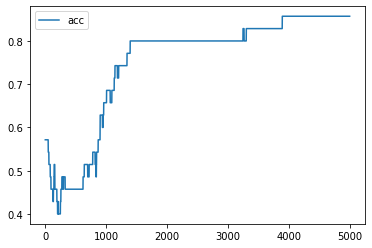

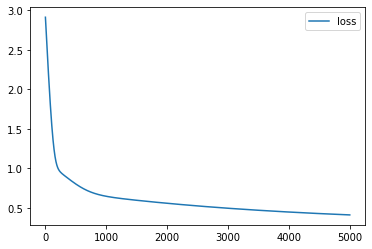

In [10]:
DataFrame({'acc': history.history['acc']}).plot()
DataFrame({'loss': history.history['loss']}).plot()

####[MLE-10]
Show weights after the training.

In [11]:
model.get_weights()

[array([[0.07224168],
        [0.1596745 ]], dtype=float32),
 array([-3.4501996], dtype=float32)]

####[MLE-11]
Plot a chart using the final weights to show the result.

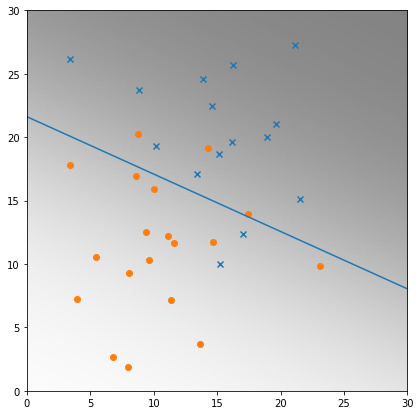

In [12]:
# 取り出したパラメーターの値を用いて、結果をグラフに表示します。
[[w1], [w2]], [b] = model.get_weights()

train_set0 = train_set[train_set['t']==0]
train_set1 = train_set[train_set['t']==1]

fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_ylim([0, 30])
subplot.set_xlim([0, 30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set0.x1, train_set0.x2, marker='o')

xs = np.linspace(0, 30, 10)
ys = - (w1*xs/w2 + b/w2)
subplot.plot(xs, ys)

field = [[(1 / (1 + np.exp(-(w1*x1 + w2*x2 + b))))
          for x1 in np.linspace(0, 30, 100)]
         for x2 in np.linspace(0, 30, 100)]
subplot.imshow(field, origin='lower', extent=(0, 30, 0, 30),
               vmin=0, vmax=1, cmap=plt.cm.gray_r, alpha=0.5)